## Gait Video Project
### Ablation Study on Task generalization framework W -> WT with Traditional ML models only 

* We will explore the performance of using feet coordinates only (merged from both front and side camera views), feet + ankle coordinates (merged from both front and side camera views), feet + ankle (merged from both front and side camera views) + knee (from the single front camera view) coordinates and all (feet + ankle (merged from both front and side camera views) + knee + hip (from the single front camera view)) coordinates on the traditional ML models. We will add frame count as an extra feature to all these data streams, i.e. we will explore, 1) feet + frame count; 2) feet + ankle + frame count; 3) feet + ankle + knee + frame count; 4) All (Default models).
* In our main traditional models, total 91 features (including the frame count and 90 CoV, range and asymmetry of the body coordinate features) were used.

In [48]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import task_gen_traditionalML
reload(task_gen_traditionalML)
from ml_utils.task_gen_traditionalML import keep_subjects_common_across_train_test, normalize, models, evaluate

In [49]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\AblationResults\\ML\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())

#Whether to save the results (confusion matrices and RoC plots) or not 
save_results = True 

,key,cohort,trial,scenario,video,PID,stride_number,frame_count,label,right hip-x-CoV,...,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
0,GVS_212_T_T1_1,HOA,BW,SLWT,GVS_212_T_T1,212,1,46,0,0.046077,...,14.426173,3.407379,10.662441,0.830365,0.502570,31.450487,8.644012,5.236678,31.182183,8.215725
1,GVS_212_T_T1_2,HOA,BW,SLWT,GVS_212_T_T1,212,2,39,0,0.021528,...,1.360847,5.155307,11.363806,4.333776,1.025647,28.266400,2.671081,6.678294,15.058825,4.903579
2,GVS_212_T_T1_3,HOA,BW,SLWT,GVS_212_T_T1,212,3,56,0,0.034394,...,1.341021,8.625363,7.159495,3.366152,1.759968,17.545787,5.921325,8.243491,9.578638,3.008162
3,GVS_212_T_T1_4,HOA,BW,SLWT,GVS_212_T_T1,212,4,53,0,0.028511,...,2.375934,6.728268,0.098235,0.999027,0.541911,7.843339,4.279617,0.748023,19.471731,5.086056
4,GVS_212_T_T1_5,HOA,BW,SLWT,GVS_212_T_T1,212,5,44,0,0.025213,...,8.525816,1.775282,0.033210,9.166863,1.354601,6.674183,8.479480,4.373622,0.315168,11.795593


In [50]:
#Trial W for training 
trialW = data[data['scenario']=='W']
#Trial WT for testing 
trialWT = data[data['scenario']=='WT']

#Trial W and WT after making sure both training and testing sets have common subjects 
trialW_reduced, trialWT_reduced = keep_subjects_common_across_train_test(trialW, trialWT)
# print ('Number of subjects in training and test sets after reduction:', len(trialW_reduced['PID'].unique()), \
#            len(trialWT_reduced['PID'].unique()))
print ('Training set (trial W):', trialW_reduced.groupby(['cohort'])['PID'].value_counts())
print ('Testing set (trial WT):', trialWT_reduced.groupby(['cohort'])['PID'].value_counts())
cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the training stride data
trialW_reduced = shuffle(trialW_reduced, random_state = 0)
trainX = trialW_reduced.drop(cols_to_drop, axis = 1)
trainY = trialW_reduced[['PID', 'label']]
print ('Training shape', trainX.shape, trainY.shape)

#Shuffling the testing stride data 
trialWT_reduced = shuffle(trialWT_reduced, random_state = 0)
testX = trialWT_reduced.drop(cols_to_drop, axis = 1)
testY = trialWT_reduced[['PID', 'label']] #PID to compute person based metrics later 
print ('Testing shape', testX.shape, testY.shape)

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(trainX, 'z')
trainX_norm = (trainX-norm_mean)/norm_sd
testX_norm = (testX-norm_mean)/norm_sd

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(trialW_reduced))
print ('HOA, MS and PD strides in training set:\n', trialW_reduced['cohort'].value_counts())

#Test Set
print('\nStrides in test set: ', len(trialWT_reduced)) 
print ('HOA, MS and PD strides in test set:\n', trialWT_reduced['cohort'].value_counts())
print ('Imbalance ratio (controls:MS:PD)= 1:X:Y\n', trialWT_reduced['cohort'].value_counts()/trialWT_reduced['cohort'].value_counts()['HOA'])

framework = 'WtoWT' #Defining the task generalization framework of interest

Original number of subjects in training and test sets: 32 26
Subjects in test set, which are not in training set
[403]
Subjects in training set, which are not in test set
[312, 102, 112, 113, 115, 123, 124]
Number of subjects in training and test sets after reduction: 25 25
Training set (trial W): cohort  PID
HOA     215    45
        218    45
        212    44
        213    43
        216    40
        219    40
        217    39
        214    38
MS      320    45
        311    43
        310    41
        322    40
        323    40
        321    39
        313    38
        314    38
        318    17
PD      406    44
        408    44
        409    44
        404    41
        405    41
        410    41
        407    39
        411    39
Name: PID, dtype: int64
Testing set (trial WT): cohort  PID
HOA     217    47
        212    46
        213    45
        218    45
        215    44
        219    44
        216    42
        214    38
MS      320    47
        323    47

In [51]:
ml_models = ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  \
             'linear_svm', 'mlp']

feet_features = [s for s in data.columns if any(x in s for x in ['toe', 'heel'])]
print ('Number of feet features = ', len(feet_features))

ankle_features = [s for s in data.columns if 'ankle' in s]
print ('Number of ankle features = ', len(ankle_features))

knee_features = [s for s in data.columns if 'knee' in s]
print ('Number of knee features = ', len(knee_features))

hip_features = [s for s in data.columns if 'hip' in s]
print ('Number of hip features = ', len(hip_features))

frame_count_feature = ['frame_count']
print ('The extra frame count feature is added to all datastreams')

#The three extra data streams we would need to run for (assuming we already have the results for the 
#fourth feet+ankle+knee+hip+frame count = All features)
datastreams = {'feet': feet_features + frame_count_feature, 'feet+ankle': feet_features + ankle_features + frame_count_feature, \
               'feet+ankle+knee': feet_features + ankle_features + knee_features + frame_count_feature}

print ('No. of features explored in each datastream: ', {x:len(datastreams[x]) for x in datastreams})
ablation_columns = list(itertools.product(ml_models,datastreams))
metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

Number of feet features =  45
Number of ankle features =  15
Number of knee features =  15
Number of hip features =  15
The extra frame count feature is added to all datastreams
No. of features explored in each datastream:  {'feet': 46, 'feet+ankle': 61, 'feet+ankle+knee': 76}


('logistic_regression', 'feet')
Stride-based model performance (Macro):  0.7273622047244095 0.7313753016259611 0.7272254491129994 0.7286467735655374 0.8776371753279384
Stride-based model performance (Micro):  0.7273622047244095 0.7273622047244095 0.7273622047244095 0.7273622047244095 None
Stride-based model performance (Weighted):  0.7273622047244095 0.7304699049029212 0.7273622047244095 0.7282550865038016 0.8776218063161605
Stride-based model performance (Class-wise):  0.7273622047244095 [0.67810026 0.69230769 0.82371795] [0.73219373 0.67771084 0.77177177] [0.70410959 0.68493151 0.79689922] None
LogisticRegression(random_state=0)
Person-based model performance (Macro):  0.92 0.9333333333333332 0.9259259259259259 0.9212962962962964 0.9907407407407408
Person-based model performance (Micro):  0.92 0.92 0.92 0.92 None
Person-based model performance (Weighted):  0.92 0.9359999999999999 0.92 0.9194444444444446 0.9905555555555556
Person-based model performance (Class-wise):  0.92 [0.8 1.  1.

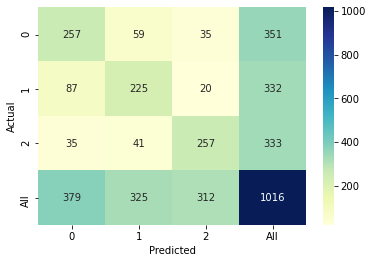

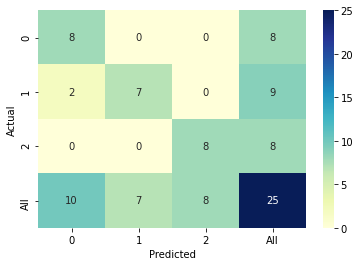

********************************
('logistic_regression', 'feet+ankle')
Stride-based model performance (Macro):  0.718503937007874 0.7208128678709155 0.7183010164937875 0.7189566207028476 0.8750177682573934
Stride-based model performance (Micro):  0.718503937007874 0.718503937007874 0.718503937007874 0.718503937007874 None
Stride-based model performance (Weighted):  0.718503937007874 0.7199812498701514 0.718503937007874 0.7186347266971415 0.8749801122930451
Stride-based model performance (Class-wise):  0.718503937007874 [0.67282322 0.70192308 0.78769231] [0.72649573 0.65963855 0.76876877] [0.69863014 0.68012422 0.7781155 ] None
LogisticRegression(random_state=0)
Person-based model performance (Macro):  0.92 0.9333333333333332 0.9259259259259259 0.9212962962962964 0.986111111111111
Person-based model performance (Micro):  0.92 0.92 0.92 0.92 None
Person-based model performance (Weighted):  0.92 0.9359999999999999 0.92 0.9194444444444446 0.9858333333333335
Person-based model performance (

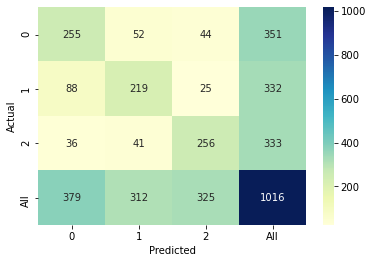

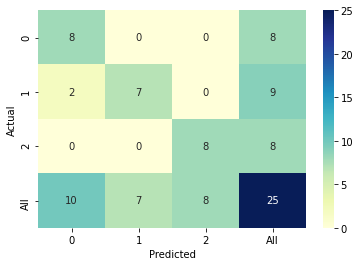

********************************
('logistic_regression', 'feet+ankle+knee')
Stride-based model performance (Macro):  0.7539370078740157 0.7549697604306603 0.7528363241214647 0.752394693943265 0.8906082351530812
Stride-based model performance (Micro):  0.7539370078740157 0.7539370078740157 0.7539370078740157 0.7539370078740157 None
Stride-based model performance (Weighted):  0.7539370078740157 0.754460335898479 0.7539370078740157 0.7526762845811578 0.890684255591967
Stride-based model performance (Class-wise):  0.7539370078740157 [0.7244898  0.72390572 0.81651376] [0.80911681 0.64759036 0.8018018 ] [0.76446837 0.6836248  0.80909091] None
LogisticRegression(random_state=0)
Person-based model performance (Macro):  0.96 0.9629629629629629 0.9629629629629629 0.9607843137254902 0.9861111111111112
Person-based model performance (Micro):  0.96 0.96 0.96 0.96 None
Person-based model performance (Weighted):  0.96 0.9644444444444444 0.96 0.96 0.9858333333333333
Person-based model performance (Cla

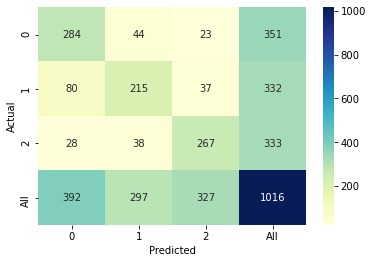

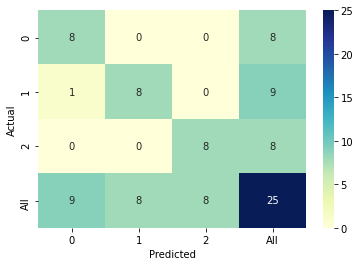

********************************
('random_forest', 'feet')
Stride-based model performance (Macro):  0.6998031496062992 0.724202544294554 0.6969721497833948 0.6991317926603697 0.876262134684714
Stride-based model performance (Micro):  0.6998031496062992 0.6998031496062992 0.6998031496062992 0.6998031496062992 None
Stride-based model performance (Weighted):  0.6998031496062992 0.7226510795563388 0.6998031496062992 0.6996819325714979 0.876496786527411
Stride-based model performance (Class-wise):  0.6998031496062992 [0.63135593 0.6292517  0.912     ] [0.84900285 0.55722892 0.68468468] [0.72417983 0.59105431 0.78216123] None
RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='log2', min_samples_leaf=2, n_estimators=40,
                       random_state=0)
Person-based model performance (Macro):  0.84 0.8614718614718614 0.8472222222222222 0.8418128654970761 0.9398148148148148
Person-based model performance (Micro):  0.84 0.84 0.84 0.8399999999

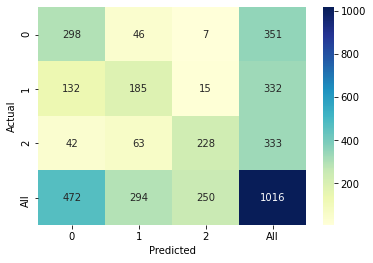

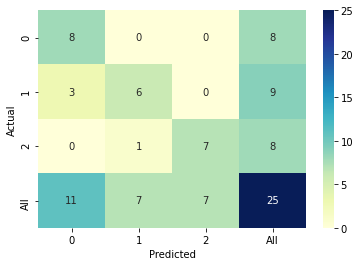

********************************
('random_forest', 'feet+ankle')
Stride-based model performance (Macro):  0.5433070866141733 0.5439524324594993 0.5409959697108291 0.5378325437233841 0.7733226782200454
Stride-based model performance (Micro):  0.5433070866141733 0.5433070866141733 0.5433070866141733 0.5433070866141733 None
Stride-based model performance (Weighted):  0.5433070866141733 0.5436670692821763 0.5433070866141733 0.5387805461391311 0.7735446871195082
Stride-based model performance (Class-wise):  0.5433070866141733 [0.52134831 0.4270073  0.68350168] [0.66096866 0.35240964 0.60960961] [0.58291457 0.38613861 0.64444444] None
RandomForestClassifier(max_depth=15, min_samples_leaf=0.1, n_estimators=40,
                       random_state=0)
Person-based model performance (Macro):  0.52 0.5178571428571429 0.5277777777777778 0.5185185185185185 0.7246817129629631
Person-based model performance (Micro):  0.52 0.52 0.52 0.52 None
Person-based model performance (Weighted):  0.52 0.514285714

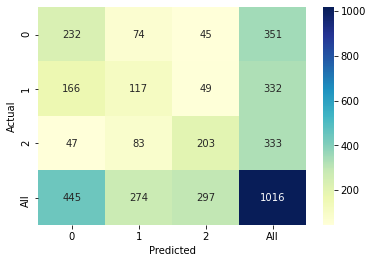

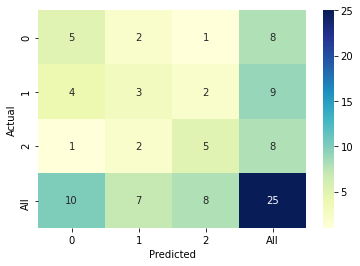

********************************
('random_forest', 'feet+ankle+knee')
Stride-based model performance (Macro):  0.5501968503937008 0.5539079271387553 0.5479817939657297 0.5463702693994998 0.788172981446074
Stride-based model performance (Micro):  0.5501968503937008 0.5501968503937008 0.5501968503937008 0.5501968503937008 None
Stride-based model performance (Weighted):  0.5501968503937008 0.5535178196220963 0.5501968503937008 0.5472202689033444 0.7882485302803881
Stride-based model performance (Class-wise):  0.5501968503937008 [0.52595937 0.4471831  0.68858131] [0.66381766 0.38253012 0.5975976 ] [0.58690176 0.41233766 0.63987138] None
RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=0.1,
                       n_estimators=40, random_state=0)
Person-based model performance (Macro):  0.48 0.47095959595959597 0.49074074074074076 0.4726608187134503 0.748263888888889
Person-based model performance (Micro):  0.48 0.48 0.48 0.48 None
Person-based model performance (We

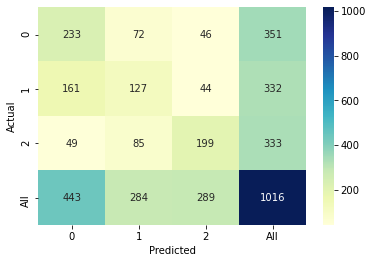

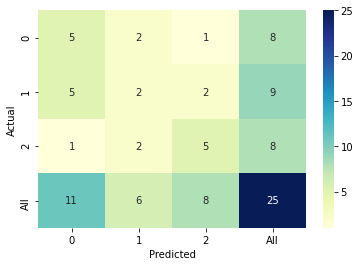

********************************
('adaboost', 'feet')
Stride-based model performance (Macro):  0.6082677165354331 0.6086647641592384 0.6063855019678313 0.603145627737343 0.7813556786113681
Stride-based model performance (Micro):  0.6082677165354331 0.6082677165354331 0.6082677165354331 0.6082677165354331 None
Stride-based model performance (Weighted):  0.6082677165354331 0.6081507994289207 0.6082677165354331 0.6037988555751481 0.7816792291121695
Stride-based model performance (Class-wise):  0.6082677165354331 [0.5771028  0.56273764 0.68615385] [0.7037037  0.44578313 0.66966967] [0.63414634 0.49747899 0.67781155] None
AdaBoostClassifier(learning_rate=1, n_estimators=75, random_state=0)
Person-based model performance (Macro):  0.76 0.7702020202020202 0.7685185185185185 0.7529239766081872 0.9114583333333334
Person-based model performance (Micro):  0.76 0.76 0.76 0.76 None
Person-based model performance (Weighted):  0.76 0.7727272727272728 0.76 0.7494736842105263 0.91
Person-based model pe

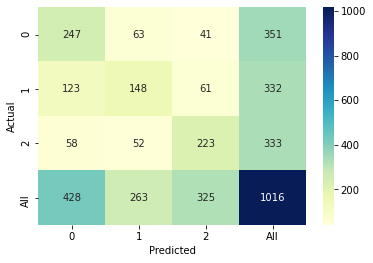

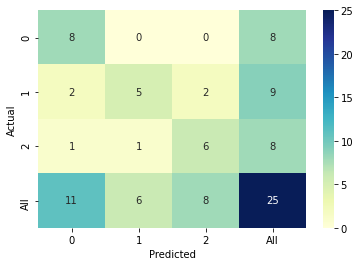

********************************
('adaboost', 'feet+ankle')
Stride-based model performance (Macro):  0.5167322834645669 0.5312096457153928 0.5142165644173676 0.5179920933122423 0.7068372950233727
Stride-based model performance (Micro):  0.5167322834645669 0.5167322834645669 0.5167322834645669 0.5167322834645669 None
Stride-based model performance (Weighted):  0.5167322834645669 0.5317582992411877 0.5167322834645669 0.5195356022631953 0.7081236619698045
Stride-based model performance (Class-wise):  0.5167322834645669 [0.55097087 0.32947977 0.71317829] [0.64672365 0.34337349 0.55255255] [0.59501966 0.33628319 0.62267343] None
AdaBoostClassifier(learning_rate=0.01, n_estimators=100, random_state=0)
Person-based model performance (Macro):  0.56 0.5797619047619048 0.5648148148148148 0.5709064327485379 0.695023148148148
Person-based model performance (Micro):  0.56 0.56 0.56 0.56 None
Person-based model performance (Weighted):  0.56 0.5725714285714285 0.56 0.5649122807017544 0.69111111111111

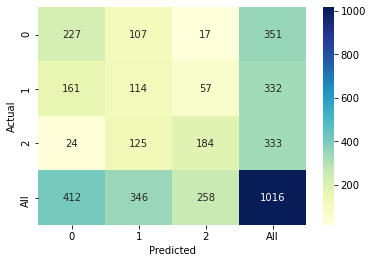

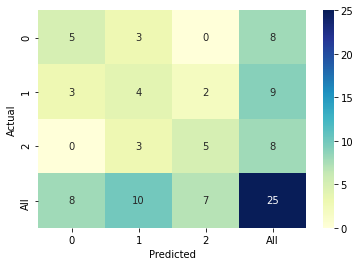

********************************
('adaboost', 'feet+ankle+knee')
Stride-based model performance (Macro):  0.5167322834645669 0.5312096457153928 0.5142165644173676 0.5179920933122423 0.7068372950233727
Stride-based model performance (Micro):  0.5167322834645669 0.5167322834645669 0.5167322834645669 0.5167322834645669 None
Stride-based model performance (Weighted):  0.5167322834645669 0.5317582992411877 0.5167322834645669 0.5195356022631953 0.7081236619698045
Stride-based model performance (Class-wise):  0.5167322834645669 [0.55097087 0.32947977 0.71317829] [0.64672365 0.34337349 0.55255255] [0.59501966 0.33628319 0.62267343] None
AdaBoostClassifier(learning_rate=0.01, n_estimators=100, random_state=0)
Person-based model performance (Macro):  0.56 0.5797619047619048 0.5648148148148148 0.5709064327485379 0.695023148148148
Person-based model performance (Micro):  0.56 0.56 0.56 0.56 None
Person-based model performance (Weighted):  0.56 0.5725714285714285 0.56 0.5649122807017544 0.691111111

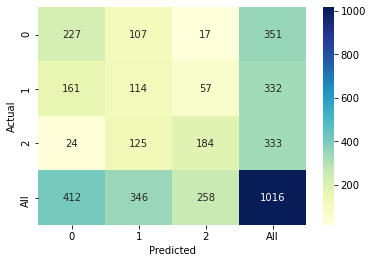

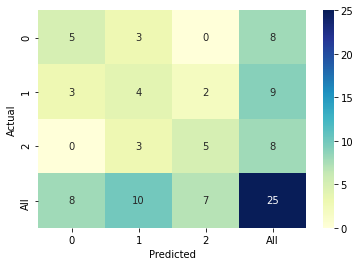

********************************
('kernel_svm', 'feet')
Stride-based model performance (Macro):  0.5954724409448819 0.6145038184840667 0.594030623147089 0.5975555426415246 0.8078458955299652
Stride-based model performance (Micro):  0.5954724409448819 0.5954724409448819 0.5954724409448819 0.5954724409448819 None
Stride-based model performance (Weighted):  0.5954724409448819 0.6135214112584967 0.5954724409448819 0.5977964495700948 0.8078436971731606
Stride-based model performance (Class-wise):  0.5954724409448819 [0.55399061 0.52339181 0.76612903] [0.67236467 0.53915663 0.57057057] [0.60746461 0.53115727 0.65404475] None
SVC(gamma=0.001, probability=True, random_state=0)
Person-based model performance (Macro):  0.6 0.6296296296296297 0.6018518518518519 0.6084656084656085 0.8246527777777777
Person-based model performance (Micro):  0.6 0.6 0.6 0.6 None
Person-based model performance (Weighted):  0.6 0.6266666666666667 0.6 0.6063492063492063 0.8233333333333335
Person-based model performance

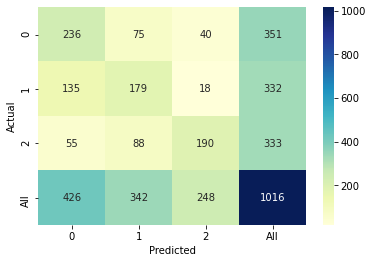

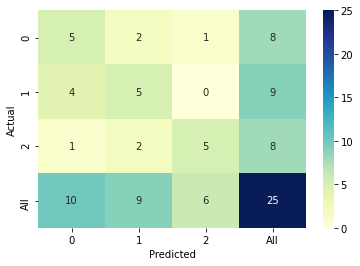

********************************
('kernel_svm', 'feet+ankle')
Stride-based model performance (Macro):  0.5787401574803149 0.5978113242516913 0.5771284104617438 0.5806676845520519 0.8131965848387089
Stride-based model performance (Micro):  0.5787401574803149 0.5787401574803149 0.5787401574803149 0.5787401574803149 None
Stride-based model performance (Weighted):  0.5787401574803149 0.5967812487002511 0.5787401574803149 0.5809485255642505 0.8131788792260404
Stride-based model performance (Class-wise):  0.5787401574803149 [0.53440367 0.5030303  0.756     ] [0.66381766 0.5        0.56756757] [0.59212198 0.50151057 0.6483705 ] None
SVC(gamma=0.001, probability=True, random_state=0)
Person-based model performance (Macro):  0.6 0.6296296296296297 0.6018518518518519 0.6084656084656085 0.8153935185185185
Person-based model performance (Micro):  0.6 0.6 0.6 0.6 None
Person-based model performance (Weighted):  0.6 0.6266666666666667 0.6 0.6063492063492063 0.8138888888888889
Person-based model perf

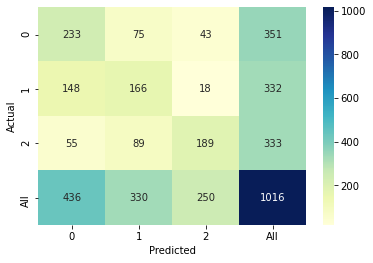

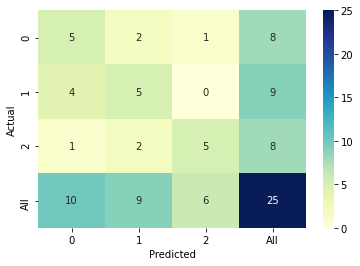

********************************
('kernel_svm', 'feet+ankle+knee')
Stride-based model performance (Macro):  0.6299212598425197 0.63651599586035 0.6294460973175833 0.6317076280343985 0.8352404553319324
Stride-based model performance (Micro):  0.6299212598425197 0.6299212598425197 0.6299212598425197 0.6299212598425197 None
Stride-based model performance (Weighted):  0.6299212598425197 0.6357976394599724 0.6299212598425197 0.6315811133364426 0.8350947764658216
Stride-based model performance (Class-wise):  0.6299212598425197 [0.59173127 0.56024096 0.75757576] [0.65242165 0.56024096 0.67567568] [0.62059621 0.56024096 0.71428571] None
SVC(gamma=0.001, probability=True, random_state=0)
Person-based model performance (Macro):  0.68 0.6805555555555555 0.6805555555555555 0.6805555555555555 0.8842592592592592
Person-based model performance (Micro):  0.68 0.68 0.68 0.68 None
Person-based model performance (Weighted):  0.68 0.68 0.68 0.68 0.8831944444444444
Person-based model performance (Class-wis

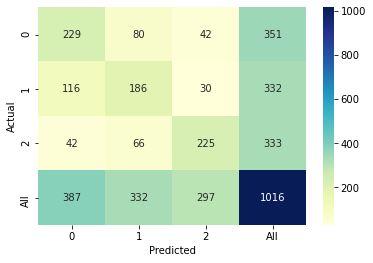

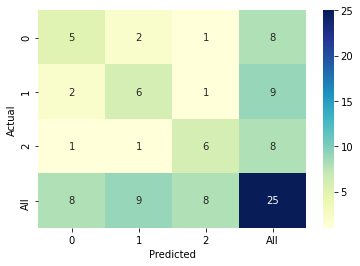

********************************
('gbm', 'feet')
Stride-based model performance (Macro):  0.7539370078740157 0.7668486690225821 0.7514322323559272 0.7522372319162365 0.9106543986062059
Stride-based model performance (Micro):  0.7539370078740157 0.7539370078740157 0.7539370078740157 0.7539370078740157 None
Stride-based model performance (Weighted):  0.7539370078740157 0.7657391061084144 0.7539370078740157 0.7528598159268917 0.910819371508585
Stride-based model performance (Class-wise):  0.7539370078740157 [0.70045045 0.69899666 0.9010989 ] [0.88603989 0.62951807 0.73873874] [0.78238994 0.66244057 0.81188119] None
GradientBoostingClassifier(learning_rate=0.15, max_depth=7, max_features=6,
                           min_samples_leaf=3, random_state=0)
Person-based model performance (Macro):  0.76 0.7936507936507936 0.7685185185185185 0.7607142857142858 0.9791666666666666
Person-based model performance (Micro):  0.76 0.76 0.76 0.76 None
Person-based model performance (Weighted):  0.76 0.79

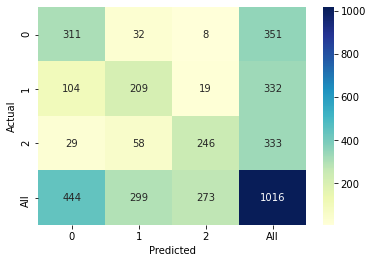

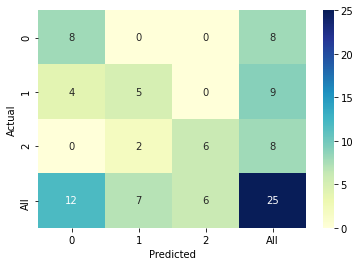

********************************
('gbm', 'feet+ankle')
Stride-based model performance (Macro):  0.7401574803149606 0.7590161609260306 0.7374907344786862 0.7388533458436372 0.9087353623832874
Stride-based model performance (Micro):  0.7401574803149606 0.7401574803149606 0.7401574803149606 0.7401574803149605 None
Stride-based model performance (Weighted):  0.7401574803149606 0.7574550192249836 0.7401574803149606 0.739307408679781 0.9088262430902182
Stride-based model performance (Class-wise):  0.7401574803149606 [0.66738661 0.6958042  0.91385768] [0.88034188 0.59939759 0.73273273] [0.75921376 0.64401294 0.81333333] None
GradientBoostingClassifier(max_depth=7, max_features=5, n_estimators=150,
                           random_state=0)
Person-based model performance (Macro):  0.8 0.8257575757575758 0.8055555555555555 0.8017101577473095 0.9699074074074074
Person-based model performance (Micro):  0.8 0.8 0.8 0.8000000000000002 None
Person-based model performance (Weighted):  0.8 0.822727272

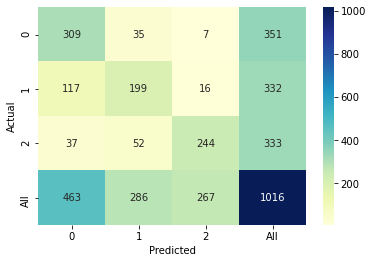

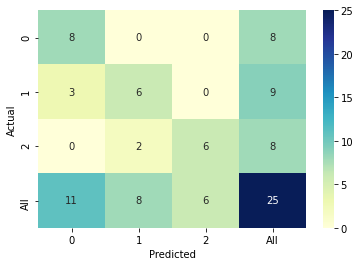

********************************
('gbm', 'feet+ankle+knee')
Stride-based model performance (Macro):  0.8051181102362205 0.809353867804572 0.8037952224699213 0.8035540826620374 0.9381264352259443
Stride-based model performance (Micro):  0.8051181102362205 0.8051181102362205 0.8051181102362205 0.8051181102362205 None
Stride-based model performance (Weighted):  0.8051181102362205 0.8083448697788279 0.8051181102362205 0.8036874971680171 0.9380976057169018
Stride-based model performance (Class-wise):  0.8051181102362205 [0.75184275 0.79929577 0.87692308] [0.87179487 0.68373494 0.85585586] [0.80738786 0.73701299 0.8662614 ] None
GradientBoostingClassifier(learning_rate=0.15, max_depth=4, max_features=4,
                           n_estimators=150, random_state=0)
Person-based model performance (Macro):  0.92 0.9259259259259259 0.9259259259259259 0.9191176470588237 0.9930555555555557
Person-based model performance (Micro):  0.92 0.92 0.92 0.92 None
Person-based model performance (Weighted):  

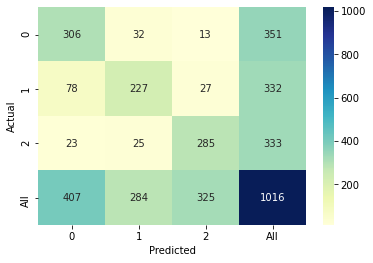

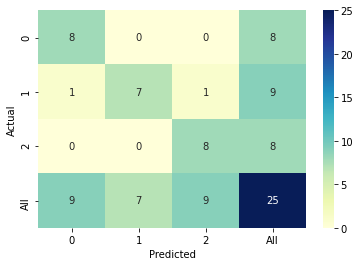

********************************
('xgboost', 'feet')
Stride-based model performance (Macro):  0.75 0.7649055659620091 0.7475761983794111 0.7485561491026426 0.9085104223435326
Stride-based model performance (Micro):  0.75 0.75 0.75 0.75 None
Stride-based model performance (Weighted):  0.75 0.7634377511836612 0.75 0.7489445364910217 0.9086079854848828
Stride-based model performance (Class-wise):  0.75 [0.6799117  0.72631579 0.88848921] [0.87749288 0.62349398 0.74174174] [0.76616915 0.67098865 0.80851064] None
XGBClassifier(colsample_bytree=0.6, gamma=0.1, max_depth=7, min_child_weight=5,
              objective='multi:softprob', subsample=1.0)
Person-based model performance (Macro):  0.8 0.8257575757575758 0.8055555555555555 0.8017101577473095 0.9837962962962963
Person-based model performance (Micro):  0.8 0.8 0.8 0.8000000000000002 None
Person-based model performance (Weighted):  0.8 0.8227272727272728 0.8 0.7978770455550642 0.9834722222222223
Person-based model performance (Class-wise)

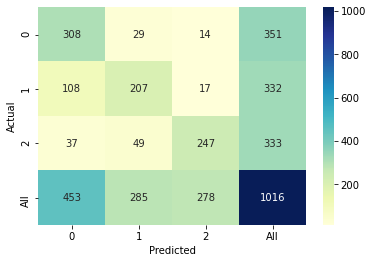

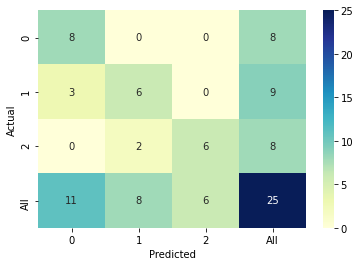

********************************
('xgboost', 'feet+ankle')
Stride-based model performance (Macro):  0.75 0.7618900431245087 0.7477694716650539 0.7486740156701227 0.9119386781144924
Stride-based model performance (Micro):  0.75 0.75 0.75 0.75 None
Stride-based model performance (Weighted):  0.75 0.7606380350188205 0.75 0.7490879578306203 0.9120083651733875
Stride-based model performance (Class-wise):  0.75 [0.68778281 0.7        0.89788732] [0.86609687 0.61144578 0.76576577] [0.7667087  0.65273312 0.82658023] None
XGBClassifier(colsample_bytree=0.6, gamma=0.5, max_depth=8,
              objective='multi:softprob', subsample=0.8)
Person-based model performance (Macro):  0.8 0.8333333333333334 0.8101851851851851 0.8000000000000002 0.9884259259259259
Person-based model performance (Micro):  0.8 0.8 0.8 0.8000000000000002 None
Person-based model performance (Weighted):  0.8 0.8333333333333333 0.8 0.7946666666666666 0.9881944444444445
Person-based model performance (Class-wise):  0.8 [0.6666

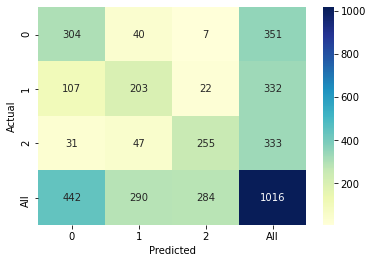

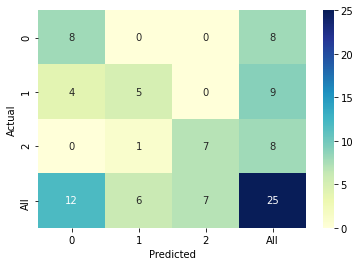

********************************
('xgboost', 'feet+ankle+knee')


In [ ]:
for col in ablation_columns:
    print (col)
    model = col[0]
    datastream = datastreams[col[1]]
#     print (regressN_trainX_norm[datastream].head())
    _, stride_person_metrics = models(trainX_norm[datastream], trainY, testX_norm[datastream], testY, model, framework, results_path, save_results, col[1])
    metrics[model] = stride_person_metrics
    print ('********************************')

metrics.index = ['stride_accuracy', 'stride_precision_macro', 'stride_precision_micro', 'stride_precision_weighted', \
                 'stride_precision_class_wise', 'stride_recall_macro', 'stride_recall_micro', \
                 'stride_recall_weighted', 'stride_recall_class_wise', \
                 'stride_F1_macro', 'stride_F1_micro', 'stride_F1_weighted', 'stride_F1_class_wise', \
                 'stride_AUC_macro', 'stride_AUC_micro', 'stride_AUC_weighted',\
                 'stride_AUC_class_wise', 'person_accuracy', 'person_precision_macro', 'person_precision_micro', \
                 'person_precision_weighted', \
                 'person_precision_class_wise', 'person_recall_macro', 'person_recall_micro', \
                 'person_recall_weighted', 'person_recall_class_wise', \
                 'person_F1_macro', 'person_F1_micro', 'person_F1_weighted', 'person_F1_class_wise', \
                 'person_AUC_macro', 'person_AUC_micro', 'person_AUC_weighted', 'person_AUC_class_wise']  
if save_results:
    metrics.to_csv(results_path+ framework + '\\task_generalize_ablation_study_'+framework+'_result_metrics.csv')

In [ ]:
metrics

In [ ]:
metrics[list(itertools.product(ml_models,['feet+ankle']))]

### Reading the final metrics from the saved file

In [ ]:
ablation_task_generalize = pd.read_csv(results_path+ framework + '\\task_generalize_ablation_study_'+framework+'_result_metrics.csv')
ablation_task_generalize.index = ablation_task_generalize['Unnamed: 0']
ablation_task_generalize.drop('Unnamed: 0', axis = 1, inplace = True)

ablation_task_generalize.columns = [literal_eval(ablation_task_generalize.loc['person_accuracy_mean'].index[idx]) for idx in range(len(ablation_task_generalize.loc['person_accuracy_mean'].index))]

In [ ]:
ablation_task_generalize

### Heatmap for person-accuracy for all datastreams and algorithms for task generalization W->WT

In [ ]:
person_accuracy_task_generlaize = pd.DataFrame(columns = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp'], index = list(datastreams.keys()))


for idx in range(len(ablation_task_generalize.columns)):
    x = ablation_task_generalize.loc['person_accuracy_mean'].index[idx][1]
    y = ablation_task_generalize.loc['person_accuracy_mean'].index[idx][0]
#     print (regressN_metrics.loc['person_accuracy'][(y, x)])
    person_accuracy_task_generlaize.loc[x, y] = ablation_task_generalize.loc['person_accuracy_mean'][(y, x)]

person_accuracy_task_generlaize = person_accuracy_task_generlaize.astype(float)

In [ ]:
#Adding the person mean accuracy for all the models using all the features 
person_accuracy_task_generlaize.loc['All features'] = [np.nan]*9

In [ ]:
ml_model_names1 = ['RF','AdaBoost', 'RBF SVM', 'GBM','Xgboost', 'DT',  'LSVM', 'LR', 'MLP']
datasets = ['Feet (Toes and Heel) + Speed', 'Feet + Ankles + Speed', 'Feet + Ankles + Knees + Speed', 'All features']

fig, axes = plt.subplots(1, 1, figsize=(10, 3.5))
sns.heatmap(person_accuracy_task_generlaize, vmin=0.3, vmax=1.0, center = 0.6, cmap="coolwarm", annot=True, linewidths=0.4, linecolor="k", \
            cbar = False, xticklabels=ml_model_names1,  yticklabels=datasets)
plt.title('Task generalization')
plt.tight_layout()
plt.savefig(results_path + framework + '\\task_generalize_ablation_study_'+framework+'_heatmap.jpg', dpi = 250)
plt.show()